![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

# Business requirement
Use machine learning to predict the mean temperature in London, England, logging your root mean squared error (RMSE) metrics using mlflow.

Build a model to predict "mean_temp" with a RMSE of 3 or less.
Use MLflow to log any models you train, their hyperparameters, and respective RMSE scores (ensuring you include "rmse" as part of the metric name).
Search all of your mlflow runs and store the results as a variable called experiment_results.

# How to approach the problem
1. Loading the data
2. Data cleaning
3. Exploratory data analysis
4. Feature selection
5. Preprocess data
6. Machine learning training and evaluation
7. Searching your logged results

In [ ]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv") 

# Start coding here
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


## Analyze the relationship
- Check missing values
- Check their correlation with pairplot


In [91]:
weather.describe()
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
weather.isna().sum() / len(weather) * 100

date                0.000000
cloud_cover         0.123851
sunshine            0.000000
global_radiation    0.123851
max_temp            0.039111
mean_temp           0.234665
min_temp            0.013037
precipitation       0.039111
pressure            0.026074
snow_depth          9.393130
dtype: float64

Some columns having missing values: cloud_cover, global_radiation, max_temp, mean_temp, min_temp, precipitation, pressure, snow_depth. Do two steps 
- Remove missing rows on the columns that have the rate of missing values < 0.05 (55)
- Perform the interpolation for missing values on the remaining rows

In [92]:
# Identify columns with missing value rate less than 0.05%
cleaned_weather = weather.copy()
missing_rates = cleaned_weather.isna().sum() / len(cleaned_weather) * 100
cols_to_dropna = missing_rates[missing_rates < 0.05].index.tolist()

# Remove rows with missing values in those columns
cleaned_weather = cleaned_weather.dropna(subset=cols_to_dropna)
cleaned_weather.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp             29
min_temp               0
precipitation          0
pressure               0
snow_depth          1429
dtype: int64

In [93]:
missing_cols = cleaned_weather.columns[weather.isna().any()].tolist()
# Impute missing values using interpolation
for col in missing_cols:
    if cleaned_weather[col].isna().sum() > 0:
        cleaned_weather[col].interpolate(method='linear', inplace=True)

# Verify that there are no missing values left
cleaned_weather.isna().sum()

C:\Users\Trung Thao\AppData\Local\Temp\ipykernel_29992\1753038015.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_weather[col].interpolate(method='linear', inplace=True)


date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

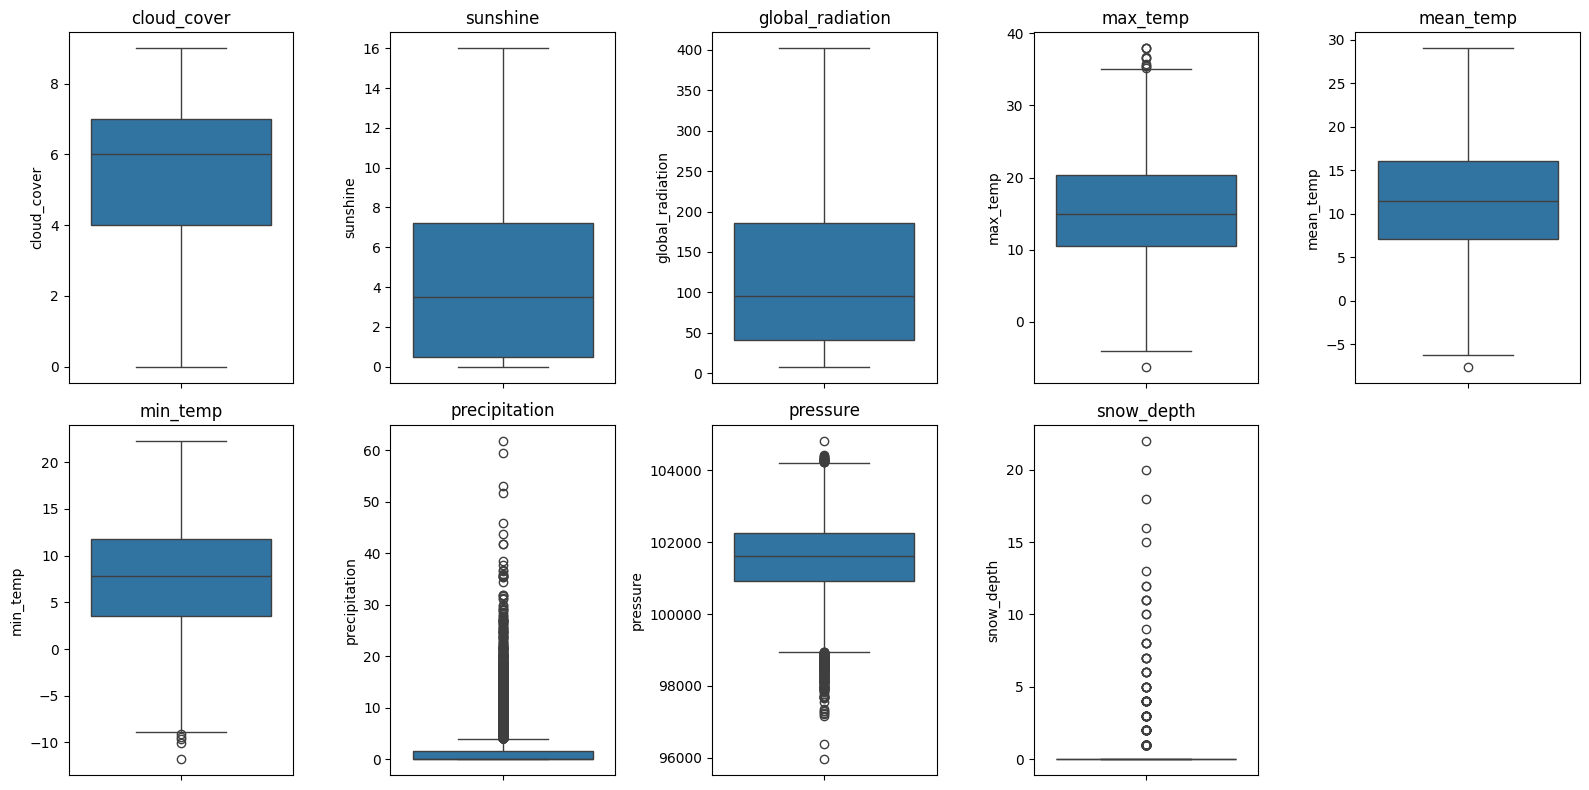

In [94]:
## Show boxplots for each feature to detect outliers
def show_boxplot():
    num_features = cleaned_weather.drop(columns=['date']).columns
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(num_features, 1):
        plt.subplot(2, (len(num_features)+1)//2, i)
        sns.boxplot(y=cleaned_weather[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()

show_boxplot()

From boxplot, some columns have outlier like precipitation, pressure. Detect the rate of outliers on them.

In [95]:
# Function to calculate outlier rate for each numeric column using IQR
def outlier_rate_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers.sum() / len(series) * 100

outlier_rates = {}
for col in cleaned_weather.columns:
    if col != 'date' and cleaned_weather[col].dtype != 'object':
        outlier_rates[col] = outlier_rate_iqr(cleaned_weather[col])

outlier_rates

{'cloud_cover': np.float64(0.0),
 'sunshine': np.float64(0.0),
 'global_radiation': np.float64(0.0),
 'max_temp': np.float64(0.07176409185803757),
 'mean_temp': np.float64(0.006524008350730688),
 'min_temp': np.float64(0.03262004175365345),
 'precipitation': np.float64(13.733037578288101),
 'pressure': np.float64(1.5853340292275575),
 'snow_depth': np.float64(0.9133611691022965)}

### Check correlation among features


In [97]:
cleaned_weather.set_index('date', inplace=True)


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [99]:
cleaned_weather['year'] = cleaned_weather.index.year
cleaned_weather['month'] = cleaned_weather.index.month
# cleaned_weather.head()
cleaned_weather.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month
date,,,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1979,1
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1979,1
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1979,1
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1979,1
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1979,1


Text(0.5, 1.0, 'Correlation Matrix')

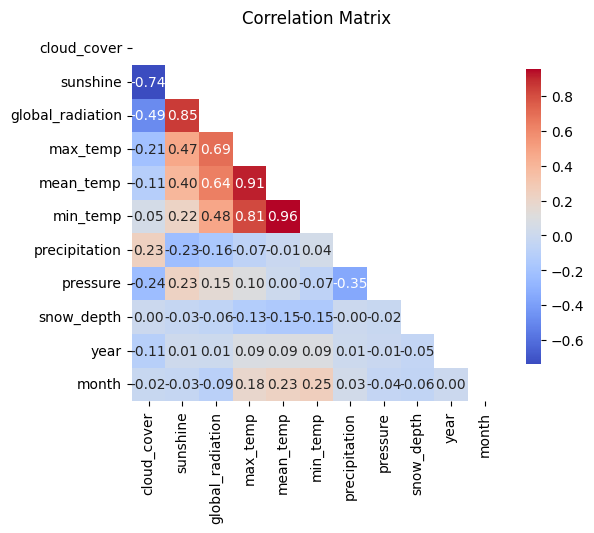

In [105]:
columns = cleaned_weather.columns.tolist()
columns

['cloud_cover',
 'sunshine',
 'global_radiation',
 'max_temp',
 'mean_temp',
 'min_temp',
 'precipitation',
 'pressure',
 'snow_depth',
 'year',
 'month']

### Check correlations between target feature vs input features.
Use pairplot to do check and verify it with heatmap

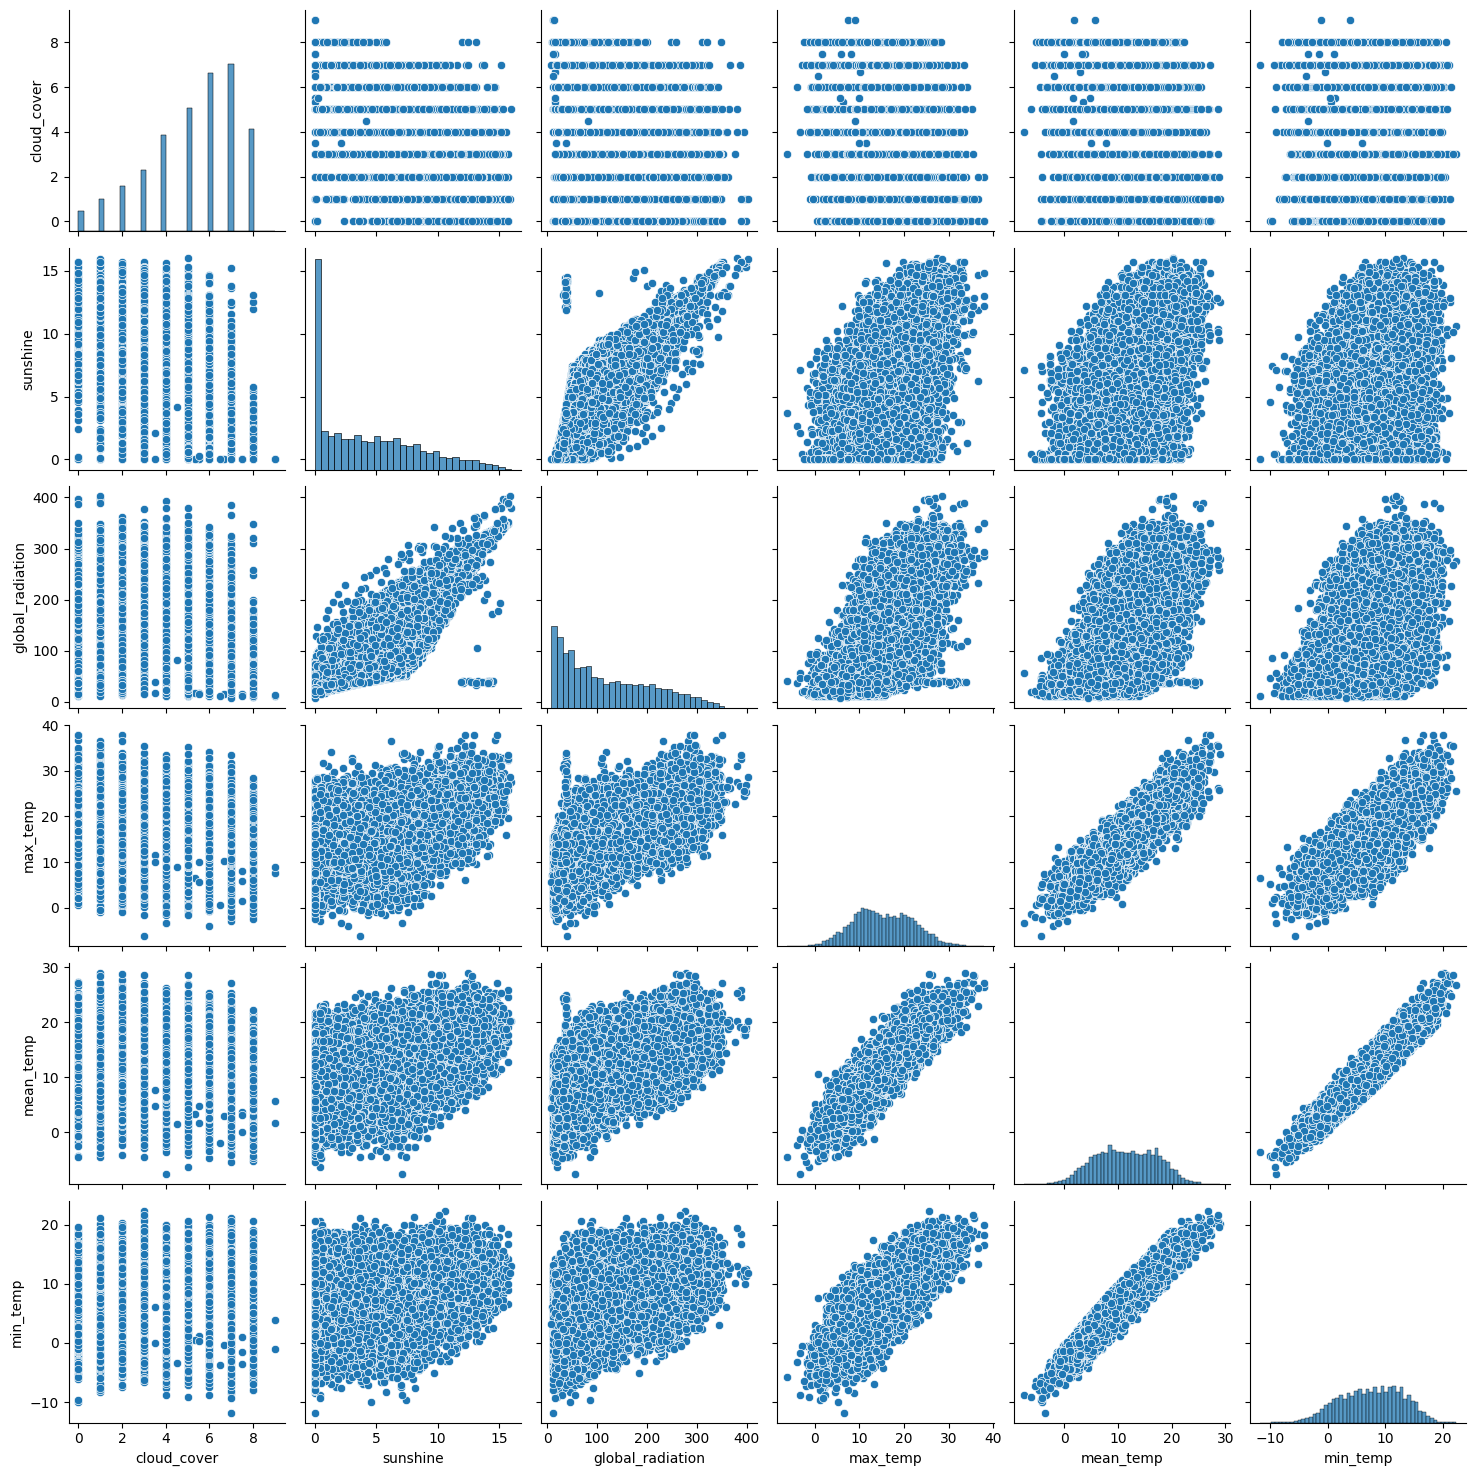

In [106]:
# Show pairplot for all features to visualize relationships
sns.pairplot(cleaned_weather[['cloud_cover',
 'sunshine',
 'global_radiation',
 'max_temp',
 'mean_temp',
 'min_temp']])
plt.show()

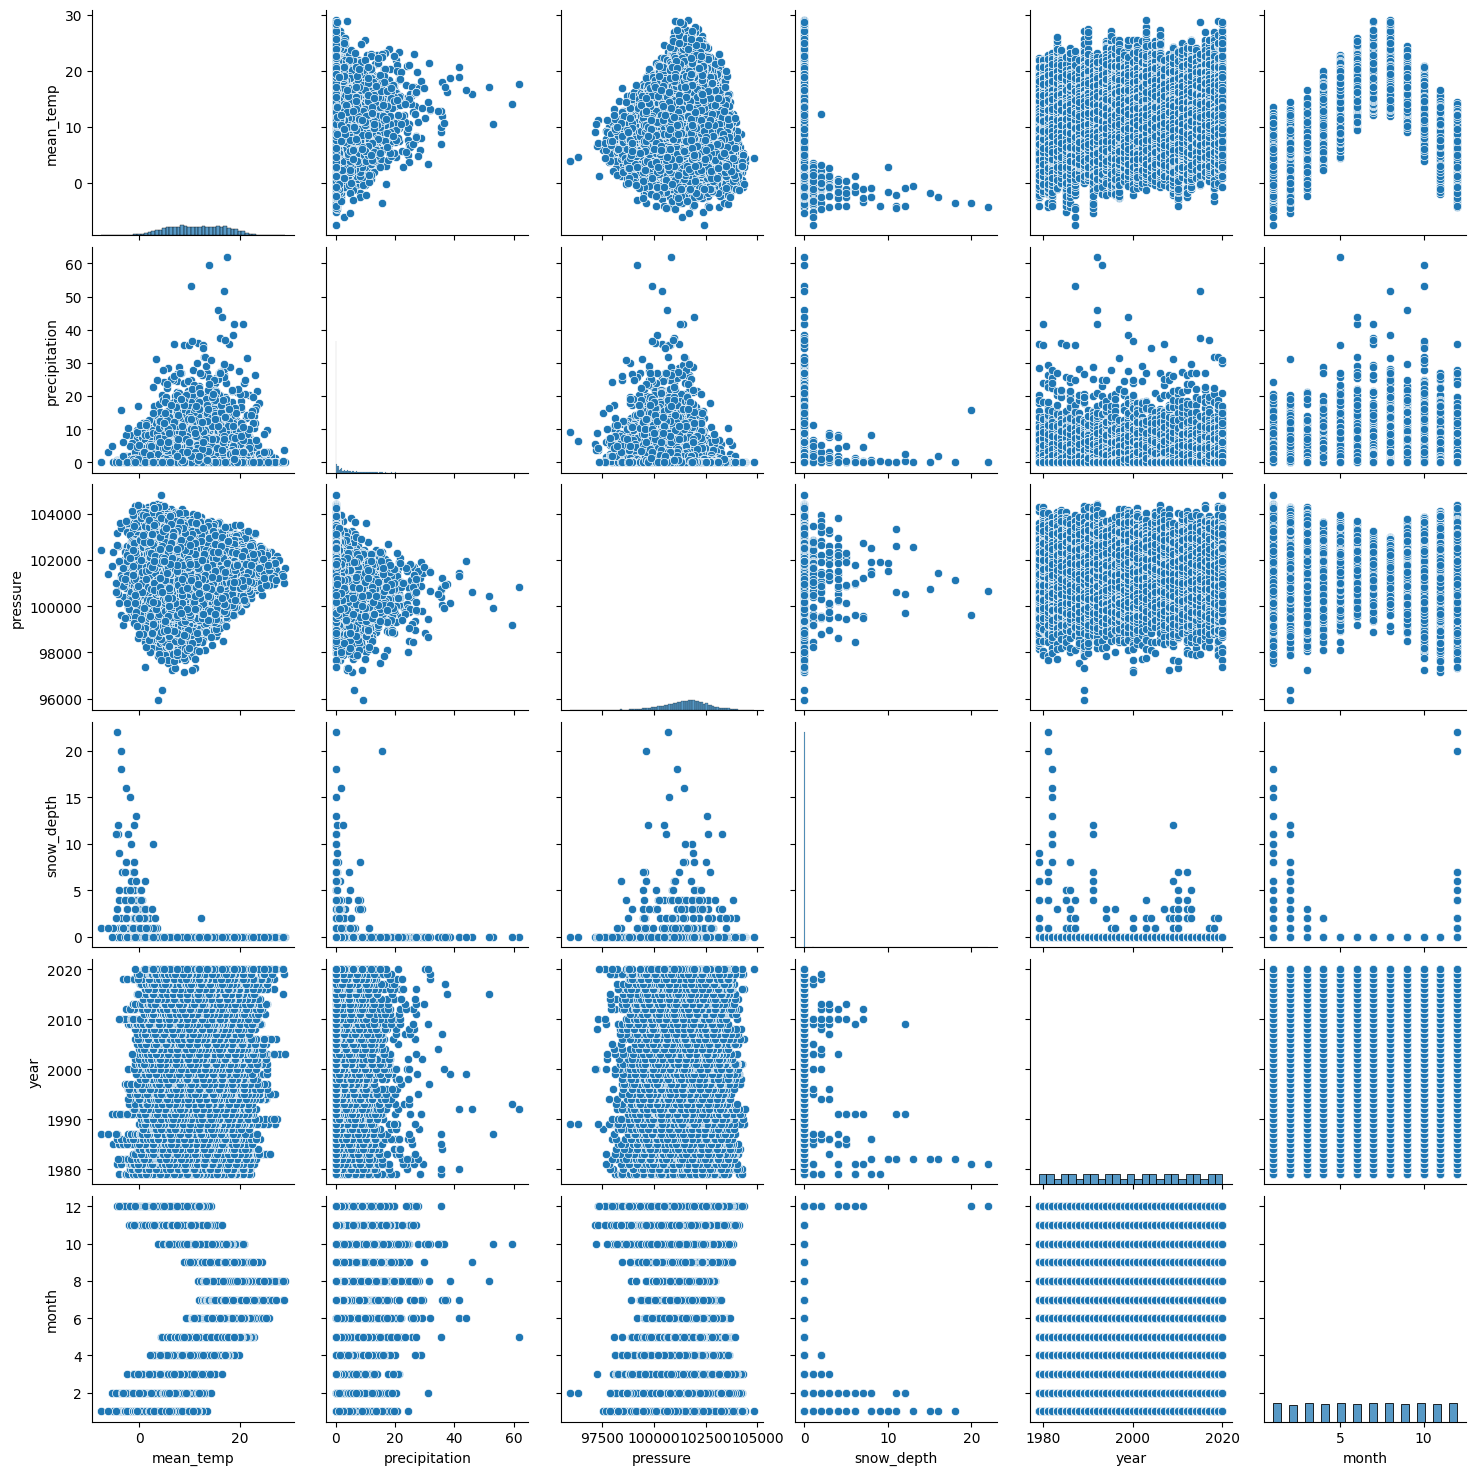

In [107]:
# Show pairplot for all features to visualize relationships

sns.pairplot(cleaned_weather[['mean_temp',
 'precipitation',
 'pressure',
 'snow_depth',
 'year',
 'month']])
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

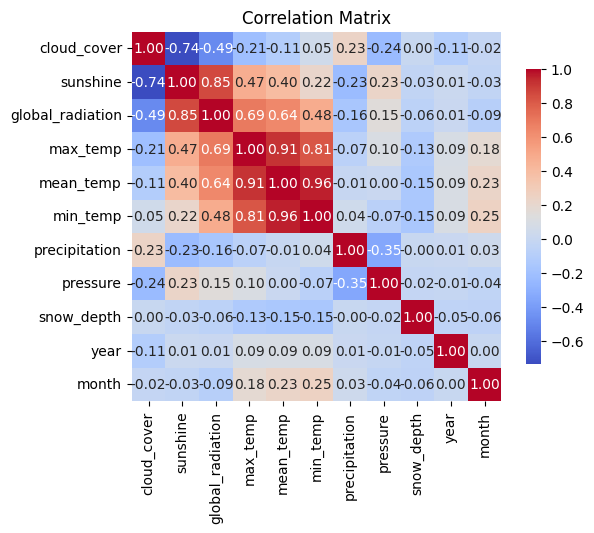

In [109]:
# Calculate the correlation matrix
correlation_matrix = cleaned_weather.corr()
# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')

From plots below, the following columns have strong the correlation with the target 'mean_temp': ['sunshine', 'global_radiation', 'max_temp', 'min_temp', 'month']. So, they are important features to predict the mean_temp.

### Check correlation between input features to remove redundant features.
Here, we only need to check the important features above.

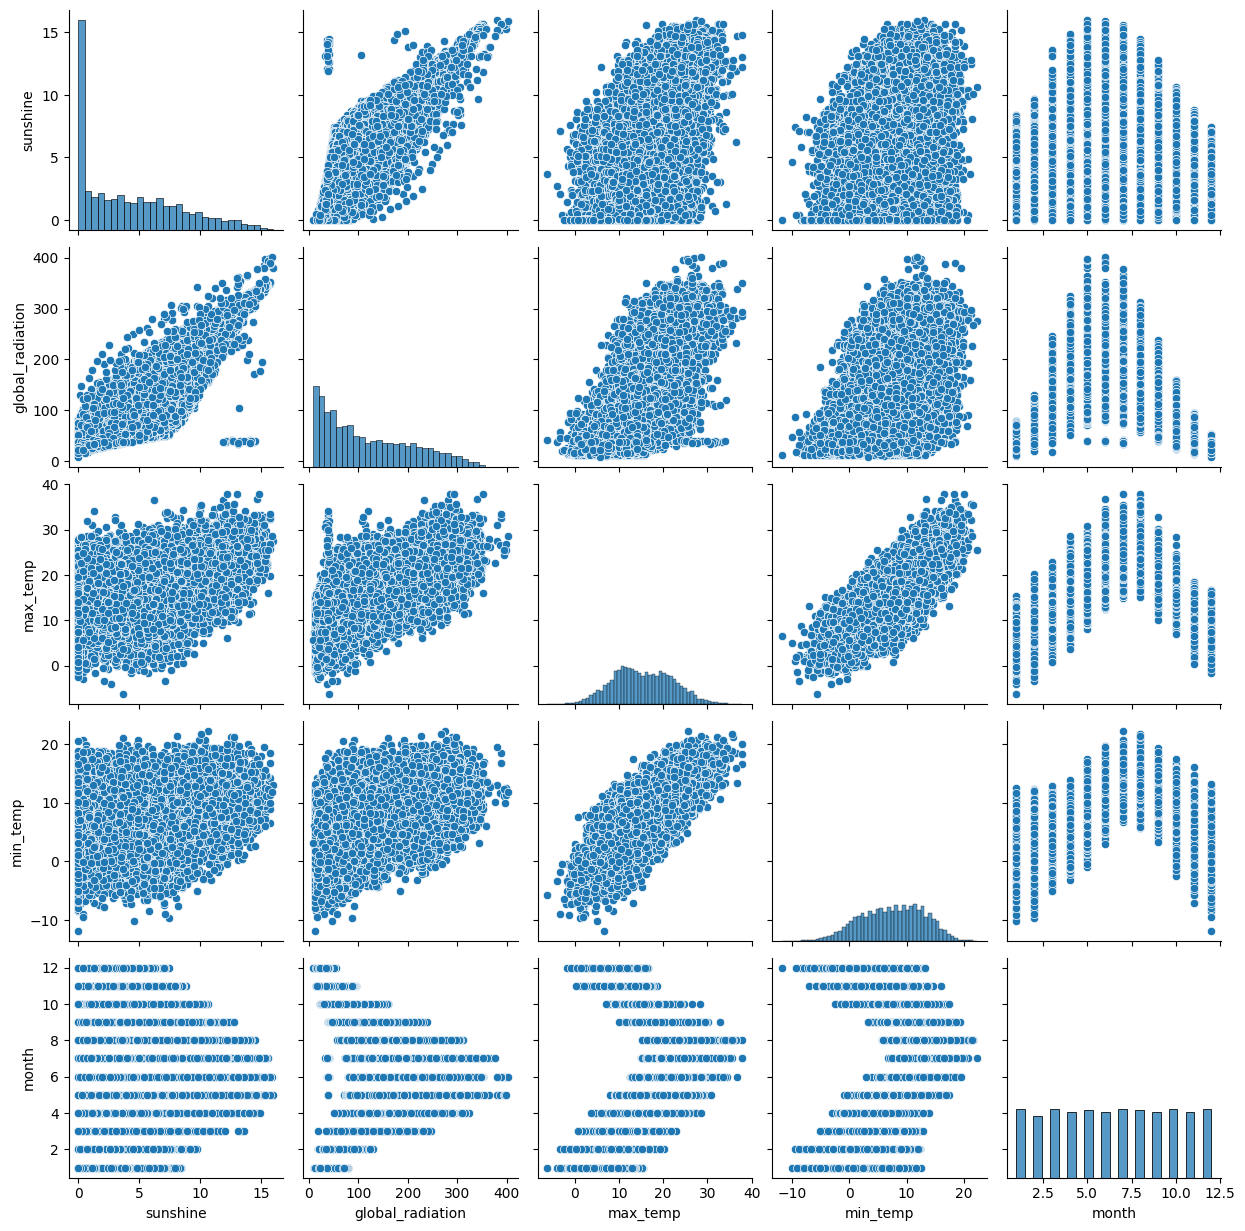

In [110]:
# Show pairplot for all features to visualize relationships

sns.pairplot(cleaned_weather[['sunshine', 'global_radiation', 'max_temp', 'min_temp', 'month']])
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

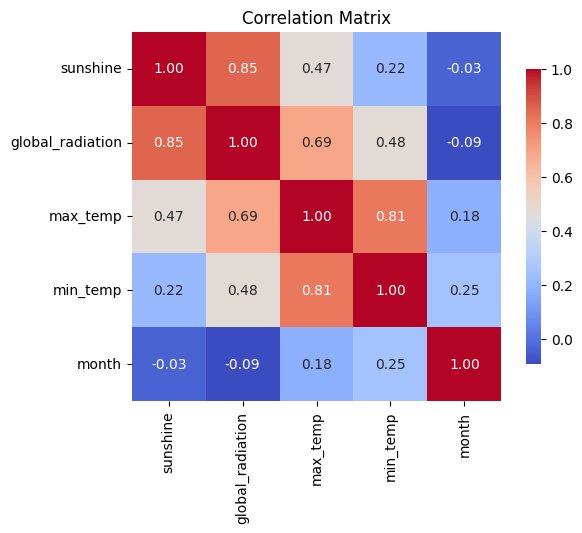

In [111]:
# Calculate the correlation matrix
correlation_matrix = cleaned_weather[['sunshine', 'global_radiation', 'max_temp', 'min_temp', 'month']].corr()
# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')

From the plots, there are a couple of features with strong correlation. They include ('sunshine', 'global_radiation') and ('min_temp', 'max_temp'). Let's keep two features 'min_temp' and 'global_radiation' and ignore two remains. Finally, we have the important features: `min_temp, global_radiation, month`.

### Use advanced techniques (PCA, VarianceThreshold) to detect important features 
- Use PCA to detect the important feature
- Use VarianceThreshold

Use VarianceThreshold, we find eight important features include the features with the strong correlation. 

In [116]:
from sklearn.feature_selection import VarianceThreshold
columns_excluded_target = [col for col in columns if col != 'mean_temp']
selector = VarianceThreshold(threshold=0.01)  # Set a threshold for variance
X = cleaned_weather[columns_excluded_target]
selector.fit(X / X.mean())
mask = selector.get_support()
masked_columns = X.columns[mask]
masked_columns

Index(['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'min_temp',
       'precipitation', 'snow_depth', 'month'],
      dtype='object')

Use PCA to detect the important feature

In [131]:
from sklearn.decomposition import PCA
pca = PCA()  # Reduce to 2 components for visualization
pca.fit(cleaned_weather[columns_excluded_target])
explained_variance_ratio_pd = pd.DataFrame(zip(columns_excluded_target, pca.explained_variance_ratio_), columns=['Feature', 'Explained Variance Ratio'])
# explained_variance_ratio_pd.sort_values(by='Explained Variance Ratio', ascending=False, inplace=True)
display(explained_variance_ratio_pd.head(10))
pca.explained_variance_ratio_

,Feature,Explained Variance Ratio
0,cloud_cover,9.928048e-01
1,sunshine,6.995317e-03
2,global_radiation,1.328351e-04
3,max_temp,3.685163e-05
4,min_temp,1.110768e-05
5,precipitation,9.421737e-06
6,pressure,5.066659e-06
7,snow_depth,3.434970e-06
8,year,9.278647e-07
9,month,2.366996e-07


array([9.92804801e-01, 6.99531672e-03, 1.32835051e-04, 3.68516331e-05,
       1.11076835e-05, 9.42173740e-06, 5.06665852e-06, 3.43497037e-06,
       9.27864747e-07, 2.36699623e-07])

From the results of two advanced techniques, we should include the feature 'cloud_cover' into the set of important features

In [134]:
important_features = ['min_temp', 'global_radiation', 'month', 'cloud_cover']

## Preprocess data
- Check the scale and variance of the selected features
- Split data into train set and test set


In [139]:
cleaned_weather[important_features].describe()


,min_temp,global_radiation,month,cloud_cover,mean_temp
count,15328.000000,15328.000000,15328.000000,15328.000000,15328.000000
mean,7.558546,118.860876,6.523356,5.269017,11.474827
std,5.326662,88.914420,3.449130,2.069120,5.728525
min,-11.800000,8.000000,1.000000,0.000000,-7.600000
25%,3.500000,41.000000,4.000000,4.000000,7.075000
50%,7.800000,95.000000,7.000000,6.000000,11.400000
75%,11.800000,186.000000,10.000000,7.000000,16.000000
max,22.300000,402.000000,12.000000,9.000000,29.000000


They have different scale like max of min_temp is 22.3 whereas max of global_radiation = 402. So, use standard scaler to force them have the same scale. Before doing it, we need to split original data into train set and test set. The purpose is to avoid data leakage.


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X = cleaned_weather[important_features]
y = cleaned_weather['mean_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [141]:
# Apply StandardScaler to INPUT FEATURES ONLY (not target)
# Fit scaler on training data only to avoid data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler fitted on training data

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=important_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=important_features, index=X_test.index)

print("Original X_train statistics:")
print(X_train.describe())
print("\nScaled X_train statistics:")
print(X_train_scaled.describe())
print(f"\nTarget variable (y_train) remains unchanged - mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")

Original X_train statistics:
           min_temp  global_radiation         month   cloud_cover
count  11496.000000      11496.000000  11496.000000  11496.000000
mean       7.553001        119.035795      6.537056      5.260612
std        5.333720         89.014164      3.451096      2.068437
min      -11.800000          8.000000      1.000000      0.000000
25%        3.500000         41.000000      4.000000      4.000000
50%        7.800000         95.000000      7.000000      6.000000
75%       11.800000        187.000000     10.000000      7.000000
max       21.700000        402.000000     12.000000      9.000000

Scaled X_train statistics:
           min_temp  global_radiation         month   cloud_cover
count  1.149600e+04      1.149600e+04  1.149600e+04  1.149600e+04
mean   2.107647e-16     -4.821010e-17  4.635587e-17 -2.385782e-16
std    1.000043e+00      1.000043e+00  1.000043e+00  1.000043e+00
min   -3.628582e+00     -1.247449e+00 -1.604504e+00 -2.543389e+00
25%   -7.599156e-01

## Build baseline model
- Use DummyRegression as baseline model

In [149]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor()
dummy_reg.fit(X_train_scaled, y_train)
dr_predictions = dummy_reg.predict(X_test_scaled)
dr_mse = mean_squared_error(y_test, dr_predictions)
dr_rmse = np.sqrt(dr_mse)
print(f"Linear Regression RMSE: {dr_rmse:.2f}")

Linear Regression RMSE: 5.69


## Build comparative model
- Use RandomForestRegressor as competitive model

In [150]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train_scaled, y_train)
rfr_predictions = rfr.predict(X_test_scaled)
rfr_mse = mean_squared_error(y_test, rfr_predictions) 
rfr_rmse = np.sqrt(rfr_mse)
print(f"Random Forest RMSE: {rfr_rmse:.2f}")

Random Forest RMSE: 1.20


In [152]:
## Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
rfr_random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_grid,
                                       n_iter=10, cv=5, verbose=2, random_state=42)
# Fit the model
rfr_random_search.fit(X_train_scaled, y_train)
# Get the best parameters
best_params = rfr_random_search.best_params_
print(f"Best parameters from RandomizedSearchCV: {best_params}")
# Use the best parameters to create a new Random Forest model
best_rfr = rfr_random_search.best_estimator_
best_rfr.fit(X_train_scaled, y_train)
best_rfr_predictions = best_rfr.predict(X_test_scaled)
best_rfr_mse = mean_squared_error(y_test, best_rfr_predictions)
best_rfr_rmse = np.sqrt(best_rfr_mse)
print(f"Best Random Forest RMSE after hyperparameter tuning: {best_rfr_rmse:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; t

c:\Users\Trung Thao\Documents\GitHub\data-science\machine_learning\Predicting Temperature in London\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Trung Thao\Documents\GitHub\data-science\machine_learning\Predicting Temperature in London\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Trung Thao\Documents\GitHub\data-science\machine_learning\Predicting Temperature in London\.venv\Lib\site-packages\sklearn\base.py"

Best parameters from RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Best Random Forest RMSE after hyperparameter tuning: 1.13


## Searching your logged results
In MLflow, use flavor for scikit-learn

In [185]:
import mlflow
import mlflow.sklearn

experiment_name = "Predicting Temperature London"

if mlflow.get_experiment_by_name(experiment_name) is None:
    # Create the experiment if it does not exist
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)




<Experiment: artifact_location='file:///c:/Users/Trung%20Thao/Documents/GitHub/data-science/machine_learning/Predicting%20Temperature%20in%20London/src/mlruns/426910037100943902', creation_time=1752138641998, experiment_id='426910037100943902', last_update_time=1752138641998, lifecycle_stage='active', name='Predicting Temperature London', tags={}>

In [181]:
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV

mlflow.sklearn.autolog()
mlflow.start_run()

mlflow.log_artifact('../src/notebook.ipynb')
## Hyperparameter tuning
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
rfr_random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_grid,
                                       n_iter=10, cv=5, verbose=2, random_state=42)
# Fit the model
rfr_random_search.fit(X_train_scaled, y_train)
# Get the best parameters
best_params = rfr_random_search.best_params_
print(f"Best parameters from RandomizedSearchCV: {best_params}")
# Use the best parameters to create a new Random Forest model
best_rfr = rfr_random_search.best_estimator_
best_rfr.fit(X_train_scaled, y_train)
best_rfr_predictions = best_rfr.predict(X_test_scaled)
best_rfr_mse = mean_squared_error(y_test, best_rfr_predictions)
best_rfr_rmse = np.sqrt(best_rfr_mse)
print(f"Best Random Forest RMSE after hyperparameter tuning: {best_rfr_rmse:.2f}")
mlflow.log_param("best_params", best_params)
mlflow.log_param("best_rfr_rmse", best_rfr_rmse)
mlflow.end_run()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; t

c:\Users\Trung Thao\Documents\GitHub\data-science\machine_learning\Predicting Temperature in London\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Trung Thao\Documents\GitHub\data-science\machine_learning\Predicting Temperature in London\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Trung Thao\Documents\GitHub\data-science\machine_learning\Predicting Temperature in London\.venv\Lib\site-packages\mlflow\utils\auto

Best parameters from RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}


2025/07/10 16:32:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 981928ecc7004eeca849e2b4a37f57f1. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'verbose\' was already logged with value=\'2\' for run ID=\'981928ecc7004eeca849e2b4a37f57f1\'. Attempted logging new value \'0\'.")]')]


Best Random Forest RMSE after hyperparameter tuning: 1.13


In [187]:
mlflow.sklearn.log_model(best_rfr)

search_results = mlflow.search_runs(experiment_names=[experiment_name], output_format="pandas")
search_results

2025/07/10 20:42:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mean_score_time,metrics.mean_fit_time,metrics.std_score_time,metrics.std_test_score,...,params.cv,params.model_type,tags.mlflow.parentRunId,tags.estimator_name,tags.mlflow.source.type,tags.mlflow.autologging,tags.estimator_class,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name
0,1d026c93074a428ea0130480d8b5b650,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:31:19.490000+00:00,2025-07-10 09:32:16.695000+00:00,0.035155,0.602122,0.000969,0.001073,...,None,None,981928ecc7004eeca849e2b4a37f57f1,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomForestRegressor,Trung Thao,ambitious-midge-984,c:\Users\Trung Thao\Documents\GitHub\data-scie...
1,1d8b884d5def4dd9b71de1ad480d45a2,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:31:19.490000+00:00,2025-07-10 09:32:16.695000+00:00,0.030535,0.575615,0.001003,0.001160,...,None,None,981928ecc7004eeca849e2b4a37f57f1,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomForestRegressor,Trung Thao,funny-hound-192,c:\Users\Trung Thao\Documents\GitHub\data-scie...
2,981928ecc7004eeca849e2b4a37f57f1,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:31:19.490000+00:00,2025-07-10 09:32:28.382000+00:00,NaN,NaN,NaN,NaN,...,5,None,None,RandomizedSearchCV,LOCAL,None,sklearn.model_selection._search.RandomizedSear...,Trung Thao,indecisive-sheep-211,c:\Users\Trung Thao\Documents\GitHub\data-scie...
3,cb9569beb1a14717ab575325cae308b1,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:31:19.490000+00:00,2025-07-10 09:32:16.695000+00:00,0.034037,0.548946,0.001704,0.001176,...,None,None,981928ecc7004eeca849e2b4a37f57f1,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomForestRegressor,Trung Thao,invincible-zebra-615,c:\Users\Trung Thao\Documents\GitHub\data-scie...
4,e937ad8da0ac436d9744050f5c17457d,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:31:19.490000+00:00,2025-07-10 09:32:16.695000+00:00,0.032718,0.658190,0.000677,0.001231,...,None,None,981928ecc7004eeca849e2b4a37f57f1,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomForestRegressor,Trung Thao,blushing-hound-470,c:\Users\Trung Thao\Documents\GitHub\data-scie...
5,f4a8daa3d29343a4a1fbff804702b970,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:31:19.490000+00:00,2025-07-10 09:32:16.695000+00:00,0.144563,2.724912,0.000682,0.001273,...,None,None,981928ecc7004eeca849e2b4a37f57f1,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomForestRegressor,Trung Thao,placid-mouse-538,c:\Users\Trung Thao\Documents\GitHub\data-scie...
6,01f39488a9c047989b8ce88d376b3e41,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:28:26.908000+00:00,2025-07-10 09:29:35.288000+00:00,NaN,NaN,NaN,NaN,...,5,RandomForestRegressor,None,RandomizedSearchCV,LOCAL,None,sklearn.model_selection._search.RandomizedSear...,Trung Thao,shivering-vole-536,c:\Users\Trung Thao\Documents\GitHub\data-scie...
7,1bc056368128427581b36f3417eb9ff6,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:28:26.908000+00:00,2025-07-10 09:29:24.574000+00:00,0.033281,0.686443,0.000714,0.001160,...,None,None,01f39488a9c047989b8ce88d376b3e41,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomForestRegressor,Trung Thao,skillful-smelt-751,c:\Users\Trung Thao\Documents\GitHub\data-scie...
8,4d4f3541cb3b4e57b39344cf7a3366a5,426910037100943902,FINISHED,file:///c:/Users/Trung%20Thao/Documents/GitHub...,2025-07-10 09:28:26.908000+00:00,2025-07-10 09:29:24.574000+00:00,0.032902,0.536209,0.000661,0.001176,...,None,None,01f39488a9c047989b8ce88d376b3e41,RandomForestRegressor,LOCAL,sklearn,sklearn.ensemble._forest.RandomFo